In [2]:
# (opzionale) Autenticati con GitHub se serve per rate limit o repo private
# !git config --global user.name "IlTuoNome"
# !git config --global user.email "tua@email.com"

# Clona la repo
!git clone https://github.com/epfml/ML_course.git

# Vai nella cartella con il notebook
%cd ML_course/labs/ex04/template

# Lista file per verifica
!ls -la

Cloning into 'ML_course'...
remote: Enumerating objects: 2536, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2536 (delta 75), reused 62 (delta 62), pack-reused 2425 (from 2)
Receiving objects: 100% (2536/2536), 1.04 GiB | 33.21 MiB/s, done.
Resolving deltas: 100% (1065/1065), done.
Updating files: 100% (153/153), done.
/content/ML_course/labs/ex04/template
total 688
drwxr-xr-x 2 root root   4096 Oct  2 12:23 .
drwxr-xr-x 3 root root   4096 Oct  2 12:23 ..
-rw-r--r-- 1 root root 150808 Oct  2 12:23 bias_variance_one_run.png
-rw-r--r-- 1 root root 455802 Oct  2 12:23 bias_variance.png
-rw-r--r-- 1 root root    798 Oct  2 12:23 build_polynomial.py
-rw-r--r-- 1 root root    682 Oct  2 12:23 costs.py
-rw-r--r-- 1 root root  18779 Oct  2 12:23 cross_validation2.png
-rw-r--r-- 1 root root  16133 Oct  2 12:23 cross_validation.png
-rw-r--r-- 1 root root   1210 Oct  2 12:23 dataEx3.csv
-rw-r--r-- 1 root root  15328 Oct  2 12:

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from test_utils import test

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [4]:
from helpers import load_data

# load dataset
x, y = load_data()

In [5]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [6]:
test(build_k_indices)

✅ Your `build_k_indices` passes some basic tests.


For the following cross_validation( ) function you need to implement, you can help yourselves of the build_poly( ) and ridge_regression( ) functions that you implemented in lab 3. Copy paste the code in the build_polynomial.py and ridge_regression.py files, they should pass the two following tests.

In [7]:
import sys
sys.path.append("ML_course/labs/ex03/template")
sys.path.append("ML_course/labs/ex02/template")
sys.path.append("ML_course/labs/ex01/template")
  # ora import funziona

In [8]:
def build_poly(x, degree):
    """
    Crea le funzioni base polinomiali per i dati di input x,
    includendo i termini da j=0 fino a j=degree (bias incluso).

    Parametri:
        x: array numpy di forma (N,) oppure (N, 1) oppure (N, d) se già con più feature
           Nota: se x ha più di una feature (d > 1), applica le potenze elemento per elemento
                 per ciascuna feature (non genera termini di interazione).
        degree: intero >= 0, grado massimo del polinomio.

    Ritorna:
        Phi: matrice delle basi polinomiali
             - Se x è (N,) o (N,1): forma (N, degree+1)
             - Se x è (N, d): forma (N, (degree+1)*d) senza interazioni tra feature
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]  # (N,) -> (N,1)

    N, d = x.shape
    if degree < 0:
        raise ValueError("degree deve essere >= 0")

    # Costruiamo le potenze per ciascuna colonna
    cols = []
    for j in range(degree + 1):
        cols.append(x**j)  # (N, d)

    # Concateniamo lungo l'asse delle feature: (N, (degree+1)*d)
    Phi = np.concatenate(cols, axis=1)
    return Phi

print(build_poly(np.arange(5),3))

[[ 1  0  0  0]
 [ 1  1  1  1]
 [ 1  2  4  8]
 [ 1  3  9 27]
 [ 1  4 16 64]]


In [9]:
import numpy as np

def ridge_regression(y, tx, lambda_):
    """
    Implementa la Ridge Regression (soluzione in forma chiusa).

    Parametri:
        y: array di forma (N,)
        tx: array di forma (N, D)
        lambda_: scalare >= 0 (coefficiente di regolarizzazione)

    Ritorna:
        w: array di forma (D,)
    """
    y = np.asarray(y).reshape(-1)        # (N,)
    tx = np.asarray(tx)                  # (N, D)
    N, D = tx.shape

    # Matrice regolarizzata: (X^T X + 2Nλ I) w = X^T y
    # Nota: alcuni testi usano Nλ o λ; qui usiamo 2Nλ per la
    # convenzione con la loss 1/(2N)||y - Xw||^2 + λ||w||^2.
    A = tx.T @ tx + (2.0 * N * lambda_) * np.eye(D)
    b = tx.T @ y

    # Risolviamo il sistema lineare
    w = np.linalg.solve(A, b)
    return w

In [10]:
from costs import compute_mse

In [11]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    N = len(y)
    val_idx = k_indices[k]
    all_idx = np.arange(N)
    train_idx = np.setdiff1d(all_idx, val_idx)
    x_train = x[train_idx]
    x_val = x[val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    # ***************************************************
    x_train_augmented = build_poly(x_train,degree)
    x_val_augmented = build_poly(x_val,degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    w = ridge_regression(y_train, x_train_augmented, lambda_)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    loss_tr = compute_mse(y_train,x_train_augmented, w)
    loss_te = compute_mse(y_val,x_val_augmented, w)

    rmse_tr = np.sqrt(2 * loss_tr)
    rmse_te = np.sqrt(2 * loss_te)
    return float(rmse_tr), float(rmse_te)

In [12]:
# can lead to a numerical error if you use an older version than Python 3.9
test(cross_validation)

❌ The are some issues with your implementation of `cross_validation`:
**********************************************************************
File "__main__", line 15, in cross_validation
Failed example:
    cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
Expected:
    (0.019866645527597114, 0.33555914361295175)
Got:
    (0.019866645527598144, 0.3355591436129497)
**********************************************************************


In [14]:
from plots import cross_validation_visualization

For polynomial expansion up to degree 7, the choice of lambda which leads to the best test rmse is 0.00853 with a test rmse of 0.291


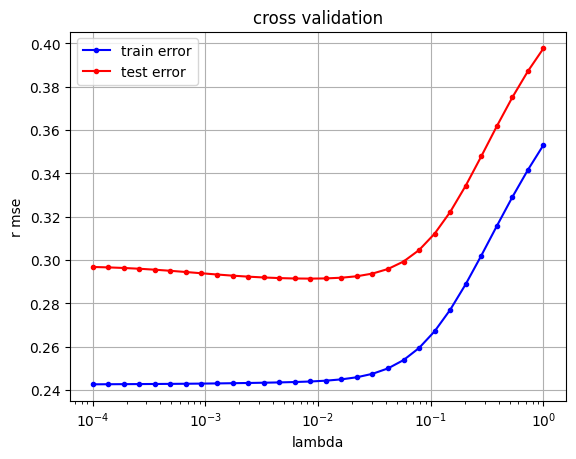

In [21]:



def cross_validation_demo(degree, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    degree = degree
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation over lambdas: TODO
    # ****** *********************************************

    for lambda_ in lambdas:
      lam_i_rmse_tr = []
      lam_i_rmse_te = []
      for k in range(k_fold):
        rmse_i_tr , rmse_i_te = cross_validation(y, x, k_indices, k, lambda_, degree)
        lam_i_rmse_tr.append(rmse_i_tr)
        lam_i_rmse_te.append(rmse_i_te)
      rmse_tr.append(sum(lam_i_rmse_tr) / len(lam_i_rmse_tr))
      rmse_te.append(sum(lam_i_rmse_te) / len(lam_i_rmse_te))

    rmse_te = np.array(rmse_te)
    best_idx = int(np.argmin(rmse_te))
    best_lambda = float(lambdas[best_idx])
    best_rmse = float(rmse_te[best_idx])


    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    print(
        "For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f"
        % (degree, best_lambda, best_rmse)
    )
    return best_lambda, best_rmse


best_lambda, best_rmse = cross_validation_demo(7, 4, np.logspace(-4, 0, 30))

Your output should look like this for seed = 12, degree = 7 and k_fold = 4:

![alt text](https://github.com/epfml/ML_course/blob/main/labs/ex04/template/cross_validation2.png?raw=1)

You can play around with the number of folds and the degree of your polynomial expansion.

For polynomial expansion up to degree 10, the choice of lambda which leads to the best test rmse is 0.01000 with a test rmse of 0.297


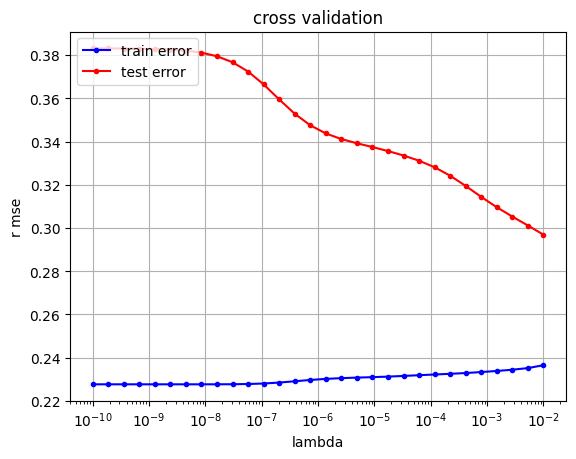

In [20]:
best_lambda, best_rmse = cross_validation_demo(10, 4, np.logspace(-10, -2, 30))

In the previous task we did a grid search over several values of $\lambda$ for a fixed degree. We can also perform a grid search amongst $\lambda$ and degrees simultaneously:

In [32]:
def best_degree_selection(degrees, k_fold, lambdas, seed=1):
    """cross validation over regularisation parameter lambda and degree.

    Args:
        degrees: shape = (d,), where d is the number of degrees to test
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_degree : integer, value of the best degree
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_degree, best_lambda)

    >>> best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
    (7, 0.004520353656360241, 0.28957280566456634)
    """

    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    rmse_tr = {}
    rmse_te = {}
    for lambda_ in lambdas:

      for d in degrees:
        rmse_tr_ij = []
        rmse_te_ij = []
        for k in range(k_fold):
          rmse_ij_tr , rmse_ij_te = cross_validation(y, x, k_indices, k, lambda_, d)
          rmse_tr_ij.append(rmse_ij_tr)
          rmse_te_ij.append(rmse_ij_te)
        rmse_tr[f"{d},{lambda_}"] = sum(rmse_tr_ij) / len(rmse_tr_ij)
        rmse_te[f"{d},{lambda_}"] = sum(rmse_te_ij) / len(rmse_te_ij)

    best_key = min(rmse_te, key=rmse_te.get)
    best_values = best_key.split(',')
    best_rmse = rmse_te[best_key]
    best_degree = int(best_values[0])
    best_lambda = float(best_values[1])


    return best_degree, best_lambda, best_rmse

In [33]:
# can lead to a numerical error if you use an older version than Python 3.9
test(best_degree_selection)
#
best_degree, best_lambda, best_rmse = best_degree_selection(
    np.arange(2, 11), 4, np.logspace(-4, 0, 30)
)
print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_rmse, best_degree, best_lambda)
)

❌ The are some issues with your implementation of `best_degree_selection`:
**********************************************************************
File "__main__", line 13, in best_degree_selection
Failed example:
    best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
Expected:
    (7, 0.004520353656360241, 0.28957280566456634)
Got:
    (7, 0.004520353656360241, 0.2876550388346475)
**********************************************************************
The best rmse of 0.288 is obtained for a degree of 7 and a lambda of 0.00452.


## Bias-Variance Decomposition

In [34]:
# true function we want to learn
def f_star(x):
    return x**3 - x**2 + 0.5


# plotting function for f_star
def plot_fstar(ax):
    xvals = np.arange(-1, 1, 0.01)
    ax.plot(xvals, f_star(xvals), linestyle="--", color="k", label="f_star")
    ax.set_ylim(-2, 2)

In [35]:
# helper plot function
def plot_poly(x, y, weights, degree, ax, alpha=0.3):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="orange", alpha=alpha)
    ax.scatter(x, y, color="b", alpha=alpha, s=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))
    ax.set_ylim(-1, 2)


# helper plot function
def plot_f(weights, degree, ax, label=None):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="black", alpha=1, label=label)
    ax.set_ylim(-1, 2)

Implement the following function: for 15 random datapoints, it finds the optimal fit (using the least square formula, with no regularisation λ) for a polynomial expansion of degree 1, 3 and 6.

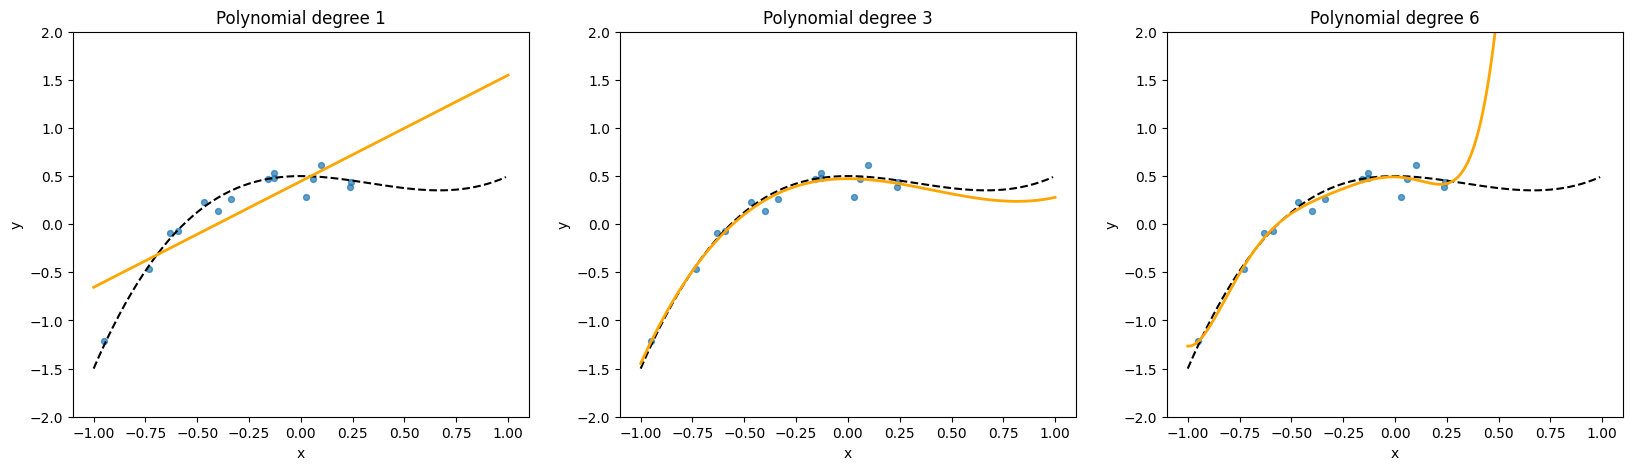

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def least_squares(y, tx):
    """Return optimal weights and MSE: solves (X^T X) w = X^T y."""
    # Assicurati che tx sia 2D e y sia 1D
    tx = np.asarray(tx)
    y = np.asarray(y).reshape(-1)

    xtx = tx.T @ tx
    xty = tx.T @ y
    w = np.linalg.solve(xtx, xty)

    e = y - tx @ w
    mse = (e @ e) / (2.0 * y.shape[0])
    return w, mse

def bias_variance_one_seed(sigma, degrees, seed):
    num_data = 15
    np.random.seed(seed)
    xs = np.random.uniform(-1, 1, num_data)
    ys = f_star(xs) + sigma * np.random.randn(num_data)

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for idx, degree in enumerate(degrees):
        Phi = build_poly(xs, degree)
        w, _ = least_squares(ys, Phi)

        x_plot = np.linspace(-1, 1, 400)
        Phi_plot = build_poly(x_plot, degree)
        y_plot = Phi_plot @ w

        axs[idx].scatter(xs, ys, s=18, alpha=0.7)
        plot_fstar(axs[idx])
        axs[idx].plot(x_plot, y_plot, color="orange", lw=2, label=f"degree {degree}")
        axs[idx].set_title(f"Polynomial degree {degree}")
        axs[idx].set_xlabel("x")
        axs[idx].set_ylabel("y")

    plt.show()

# chiamata
bias_variance_one_seed(0.1, [1, 3, 6], seed=2)

Your output should ressemble (for seed = 2) to this:
![alt text](https://github.com/epfml/ML_course/blob/main/labs/ex04/template/bias_variance_one_run.png?raw=1)

Now to illustrate the bias variance tradeoff we will repeat many times the previous experiment but using a different random seed each time. We also plot (in plain black) the mean of all the orange functions obtained.

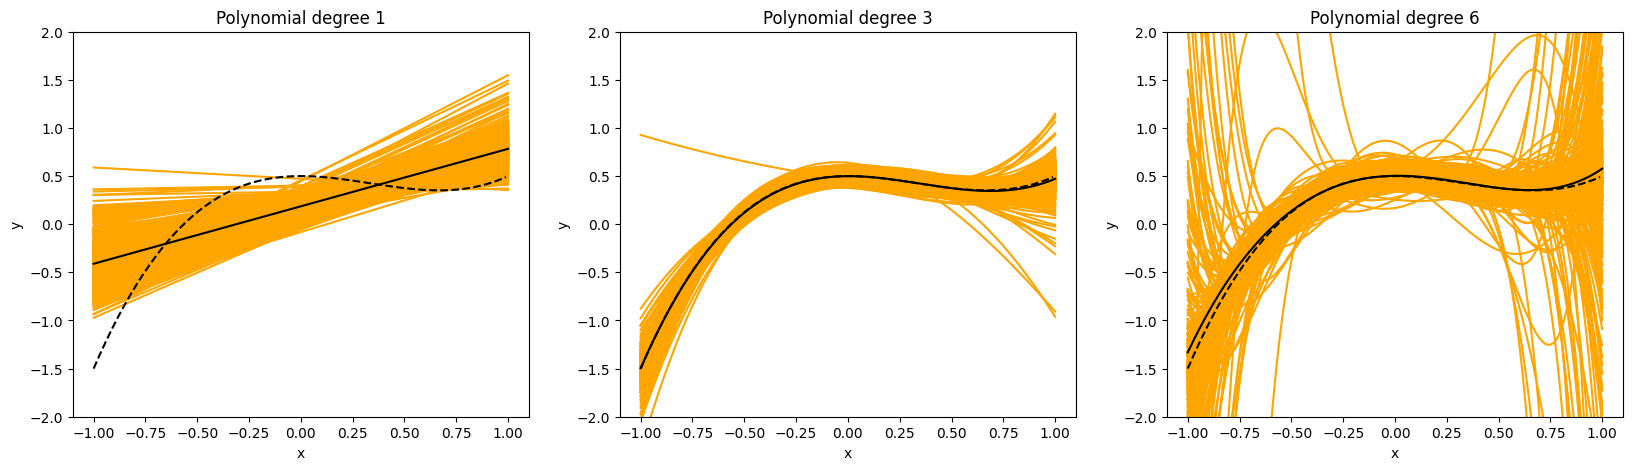

In [64]:
def bias_variance_demo(sigma, degrees):
    """Illustration of the bias-variance tradeoff.

    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
    Returns:
    """
    # define parameters
    seeds = range(400)  # number of runs
    num_data = 15

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for index_degree, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        y_values = np.zeros([400,400])
        for seed in seeds:
          np.random.seed(seed)
          xs = np.random.uniform(-1, 1, num_data)
          ys = f_star(xs) + sigma * np.random.randn(num_data)
          Phi = build_poly(xs, degree)
          w, _ = least_squares(ys, Phi)

          x_plot = np.linspace(-1, 1, 400)
          Phi_plot = build_poly(x_plot, degree)
          y_plot = Phi_plot @ w
          y_values[seed] = y_plot
          axs[index_degree].plot(x_plot, y_plot, color="orange")

        y_means = y_values.mean(axis=0)
        axs[index_degree].plot(x_plot, y_means, color="black")
        axs[index_degree].set_title(f"Polynomial degree {degree}")
        axs[index_degree].set_xlabel("x")
        axs[index_degree].set_ylabel("y")
        plot_fstar(axs[index_degree])
    plt.show()


bias_variance_demo(0.1, [1, 3, 6])

Your output should ressemble to this:
![alt text](https://github.com/epfml/ML_course/blob/main/labs/ex04/template/bias_variance.png?raw=1)